# 1. Data Preparation

In [ ]:
# !mv /kaggle/input/dataset-for-ant-bee-cockroach-spider-images

In [ ]:
from pathlib import Path

# data_path = Path('/content/drive/MyDrive/datasets')
# image_path = data_path / "dataset"

data_path = Path('/kaggle/input')
image_path = data_path / "dataset-for-ant-bee-cockroach-spider-images"

In [66]:
import os

def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

there are 2 directories and 0 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images'.
there are 4 directories and 0 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/test_set'.
there are 0 directories and 100 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/test_set/spider'.
there are 0 directories and 100 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/test_set/ant'.
there are 0 directories and 100 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/test_set/bee'.
there are 0 directories and 100 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/test_set/cockroach'.
there are 4 directories and 0 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/training_set'.
there are 0 directories and 399 images in '/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/training_set/spider'.
there are 0 directories and 400 images in '/kaggle/input/dataset-for-ant-bee-co

## 1.2 setting train dir and test dir

In [67]:
train_dir = image_path / 'training_set'
test_dir  = image_path / 'test_set'
train_dir, test_dir

(PosixPath('/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/training_set'),
 PosixPath('/kaggle/input/dataset-for-ant-bee-cockroach-spider-images/test_set'))

## 1.3 Visualizing data

random image path  : /kaggle/input/dataset-for-ant-bee-cockroach-spider-images/training_set/cockroach/cockroach_011.png
image class        : cockroach
image height       : 500
image width        : 333


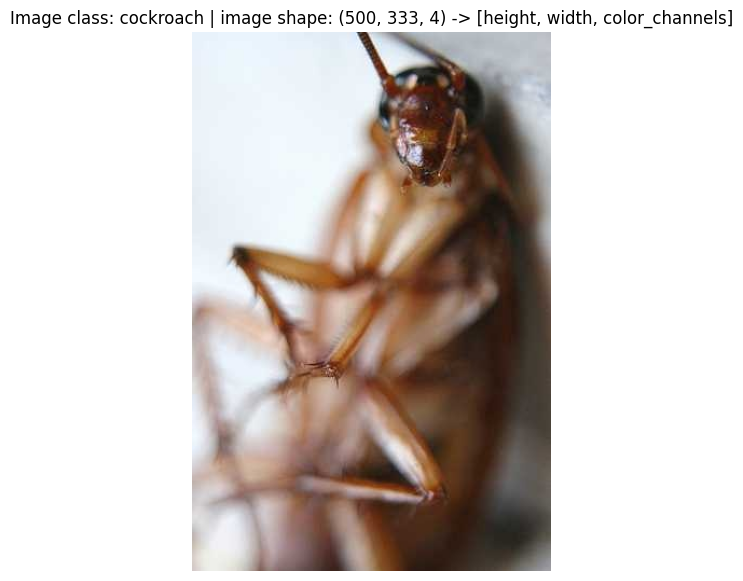

In [68]:
import random
from PIL import Image
import glob


# get all the image paths
image_path_list = list(image_path.glob("*/*/*.png"))
# image_path_list.extend(image_path.glob("*/*/*.avif"))

# pick a random image path
random_image_path = random.choice(image_path_list)

# get image class from path name
image_class = random_image_path.parent.stem

# open image
image = Image.open(random_image_path)


# print meta data
print(f"random image path  : {random_image_path}")
print(f"image class        : {image_class}")
print(f"image height       : {image.height}")
print(f"image width        : {image.width}")
# img



import numpy as np
import matplotlib.pyplot as plt

image_as_array = np.asarray(image)


plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | image shape: {image_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 1.3. image transformation using `torchvision.transforms`

In [69]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

## 1.4 Loading image using `torchvision.datasets.ImageFolder`

In [70]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1599
     Root location: /kaggle/input/dataset-for-ant-bee-cockroach-spider-images/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 400
     Root location: /kaggle/input/dataset-for-ant-bee-cockroach-spider-images/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [71]:
# get class names as list
class_names = train_data.classes
print(f"Class names are: {class_names}")

print("\n-------------------------------------------------------------\n")
# get class names as python dictionary
class_name_dict = train_data.class_to_idx
print(f"Class names in dict : \n{class_name_dict}")

Class names are: ['ant', 'bee', 'cockroach', 'spider']

-------------------------------------------------------------

Class names in dict : 
{'ant': 0, 'bee': 1, 'cockroach': 2, 'spider': 3}


## 1.5 Load data using `torch.utils.data.DataLoader`

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [73]:
from torch.utils.data import DataLoader
import os



BATCH_SIZE = 32
NUM_WORKERS=os.cpu_count()


train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

# 2. Building CNN model

In [74]:
from torch import nn

class InsectClassificationCNN(nn.Module):
  """
    Model architecture for classification of four kinds insects:
    1. Ant
    2. Bee
    3. Cockroach
    4. Spider
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*32*32,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1 : {x.shape}")

    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2 : {x.shape}")

    x = self.classifier(x)
    # print(f"Output shape of classifier : {x.shape}")
    return x

# 3. functions: `train_step()`, `test_step()`, `train_loop()`, `plot_loss_curve()`

## 3.1 Functionzing the training loop (`train_step()`)

In [75]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  #  performs a training with model trying to learn on data_loader
  train_loss, train_acc = 0, 0

  # put model into training mode
  model.train()

  # add a loop to loop through training batches
  for batch, (X, y) in enumerate(data_loader):
    # put data on target device
    X, y = X.to(device), y.to(device)

    # 1. forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()  # accumulate train loss


    # 3. optimzer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimzer step
    optimizer.step()

    # calculate train accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)      # go from raw logits -> prediction labels


    # print what's happening
    # if batch %  400 == 0:
    #   print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")
  # divide total train loss by length of train dataloader
  # adjust metrics
  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)

  # print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc: .2f}%")
  return train_loss, train_acc

## 3.2 Functionizing the testing loop (`test_step()`)

In [76]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
  """ Performs the testing loop step on the model goind over data_loader """
  ### TESTING
  test_loss, test_acc = 0,0


  # Put the model into eval mode
  model.eval()

  # turn on inference mode
  with torch.inference_mode():
    for X, y in data_loader:
      # put the data X and y into  device
      X, y = X.to(device), y.to(device)

      # 1 forward pass (outputs raw logits )
      test_pred_logits = model(X)

      # 2 calculate  the loss (accumulatively)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # 3. calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)      # go from raw logits -> prediction labels

    # calculate the test loss and average per batc/h
    test_loss /= len(data_loader)

    # calculate the test accuracy average per batch
    test_acc /= len(data_loader)

  # print what's happening
  # print(f"\nTest loss: {train_loss:.4f}, Test accuracy: {test_acc:.4f}% \n")
  return test_loss, test_acc

## 3.3. Functionizing the train loop (`train_step()`)

In [80]:
!pip install tqdm

In [81]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device ):

  results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                           data_loader=train_dataloader,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           device=device)
    test_loss, test_acc = test_step(model=model,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           device=device)

    print(f"Epoch: {epoch} | Train loss : {train_loss:.4f} | Train acc: {train_acc*100:.4f}% | Test acc: {test_acc*100:.4f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


  return results

## 3.4. Plot loss function (`plot_loss_curves()`)

In [78]:
def plot_loss_curves(results: dict[str, list[float]]):
  """ Plot the training curves of a results dictionary"""
  # get the loss value of resul's dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # get the accuracy values of the results dictionary (training and loss )
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # number of epoch
  epochs = range(len(results["train_loss"]))


  # setup a plot
  plt.figure(figsize=(15,7))

  # plotting loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train loss')
  plt.plot(epochs, test_loss, label="test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


  # plotting accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train accuracy')
  plt.plot(epochs, test_accuracy, label="test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

# 4. Training Model

## 4.1 `model_0`



* EPOCH = 15
* LR = 0.001
* hidden_units = 600

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setting number of epochs
NUM_EPOCHS = 15
LEARNING_RATE=0.01
hidden_units = 600


print(f"Total epochs : {NUM_EPOCHS}, \t Learning Rate: {LEARNING_RATE} \t Hidden Units : {hidden_units}")
print("============================================================================\n\n")

model_0 = InsectClassificationCNN(input_shape=3,  # no of color channels in our image data
                                  hidden_units=hidden_units,
                                  output_shape=len(class_names)).to(device)



# picking a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=LEARNING_RATE)




from timeit import default_timer as timer


start_timer = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS
                        )
stop_timer = timer()

total_time_model_0 = stop_timer - start_timer

print(f"Total training time: {total_time_model_0:.3f} seconds")

In [ ]:
plot_loss_curves(model_0_results)

## 4.2 `model_1`



* EPOCH = 25
* LR = 0.0001
* hidden_units = 600

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# setting number of epochs
NUM_EPOCHS = 25
LEARNING_RATE=0.0001
hidden_units = 600


print(f"Total epochs : {NUM_EPOCHS}, \t Learning Rate: {LEARNING_RATE} \t Hidden Units : {hidden_units}")
print("============================================================================\n\n")

model_1 = InsectClassificationCNN(input_shape=3,  # no of color channels in our image data
                                  hidden_units=hidden_units,
                                  output_shape=len(class_names)).to(device)



# picking a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=LEARNING_RATE)




from timeit import default_timer as timer


start_timer = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS
                        )
stop_timer = timer()

total_time_model_1 = stop_timer - start_timer

print(f"Total training time: {total_time_model_1:.3f} seconds")

In [ ]:
plot_loss_curves(model_1_results)

In [ ]:
!nvidia-smi

# How to deal with underfitting and overfitting


### **Method to improve a Model (reduce overfitting)**

* Get more data 
* Data Augmentation
* Better data
* Use Transfer Learning
* Simplify your model
* Use learning rate decay - to slowly decrease the learning rate as model trains. The closer you get to the convergence, the smaller you'll want your wight updates to be.
* Use early stopping - Early stopping stops the model training *before* it begins to overfit. As in, 



### **Method to improve a model (reduce underfitting)**

* Add more layers/units to your model
* Tweak the learning rate
* Train for longer 
* Use Transfer Learning
* Use less Regularization


# 5. Replica of above CNN architecture with data augmentation



## 5.1 **data augmentation**

### 5.1.1 Create data transform with data augmentation 

In [17]:
# Create training transform with TrivialAugment

from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()

])

### 5.1.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [56]:
# turn ImageFolder into Datasets
from torchvision import datasets

train_data_augmented  = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                    transform=test_transform_simple)

In [7]:
# turn our Datasets into DataLoaders
import os 
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

## 5.2 Construct and train **model_2**

In [63]:
# create model_2 and send it to the target device 
torch.manual_seed(42)
model_2 = InsectClassificationCNN(input_shape=3,
                                 hidden_units=10,
                                 output_shape=len(train_data_augmented.classes)).to(device)
model_2

InsectClassificationCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=4, bias=True)
  )
)

In [ ]:
# set the manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 
EPOCHS = 10
HIDDEN_UNITS = 500
LEARNING_RATE = 0.001


print(f"Total epochs: {EPOCHS}, \t Hidden units: {HIDDEN_UNITS}, \t Learning Rate: {LEARNING_RATE}")
print("\n---------------------------------------\n")
# setup loss function and optimizer function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                            lr=LEARNING_RATE)

from timeit import default_timer as  timer
# start time
model_2_start_time = timer()

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
# stop timer
model_2_stop_time = timer()

model_2_total_time = model_2_start_time - model_2_stop_time

print(f"The total time for training the models is: {model_2_total_time} seconds")

In [ ]:
plot_loss_curve(model_2_results)

## 5.3 Construct and train **model_3**

### model_3 

* EPOCHS = 40
* HIDDEN_UNITS = 50
* LEARNING_RATE = 0.001


In [82]:
# set the manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 
EPOCHS = 40
HIDDEN_UNITS = 50
LEARNING_RATE = 0.001


print(f"Total epochs: {EPOCHS}, \t Hidden units: {HIDDEN_UNITS}, \t Learning Rate: {LEARNING_RATE}")
print("\n---------------------------------------\n")

model_3 = InsectClassificationCNN(input_shape=3,
                                 hidden_units=HIDDEN_UNITS,
                                 output_shape=len(train_data_augmented.classes)).to(device)

# setup loss function and optimizer function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=LEARNING_RATE)

from timeit import default_timer as  timer
# start time
model_3_start_time = timer()

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
# stop timer
model_3_stop_time = timer()

model_3_total_time = model_3_stop_time - model_3_start_time

print(f"The total time for training the models is: {model_3_total_time} seconds")

Total epochs: 40, 	 Hidden units: 50, 	 Learning Rate: 0.001

---------------------------------------



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.3808 | Train acc: 29.6351% | Test acc: 37.0192%
Epoch: 1 | Train loss : 1.3396 | Train acc: 33.7722% | Test acc: 34.1346%
Epoch: 2 | Train loss : 1.3352 | Train acc: 33.3931% | Test acc: 39.4231%
Epoch: 3 | Train loss : 1.2847 | Train acc: 38.4516% | Test acc: 42.3077%
Epoch: 4 | Train loss : 1.2684 | Train acc: 42.5222% | Test acc: 44.9519%
Epoch: 5 | Train loss : 1.2490 | Train acc: 41.2077% | Test acc: 40.3846%
Epoch: 6 | Train loss : 1.2306 | Train acc: 42.3347% | Test acc: 43.7500%
Epoch: 7 | Train loss : 1.1972 | Train acc: 48.1512% | Test acc: 38.9423%
Epoch: 8 | Train loss : 1.1841 | Train acc: 47.0867% | Test acc: 49.7596%
Epoch: 9 | Train loss : 1.1658 | Train acc: 49.0343% | Test acc: 51.9231%
Epoch: 10 | Train loss : 1.1222 | Train acc: 50.7702% | Test acc: 49.5192%
Epoch: 11 | Train loss : 1.0898 | Train acc: 54.4617% | Test acc: 53.6058%
Epoch: 12 | Train loss : 1.0900 | Train acc: 54.9052% | Test acc: 52.8846%
Epoch: 13 | Train loss : 1.0632 | T

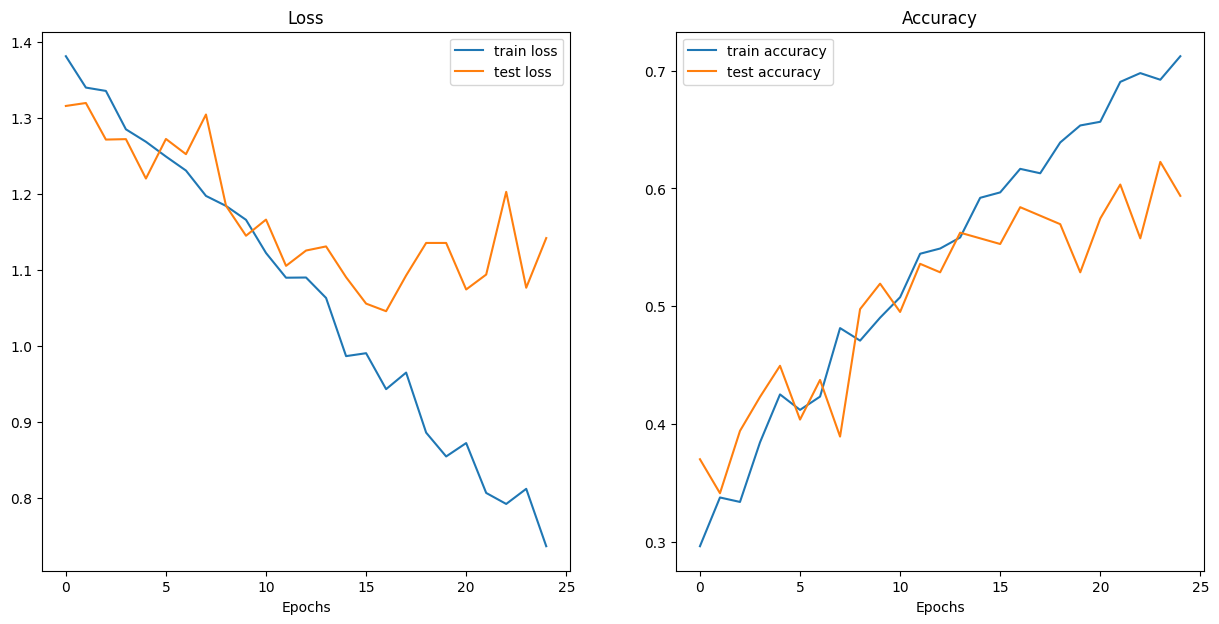

In [84]:
plot_loss_curves(model_3_results)

## 5.4 Construct and train **model_4**

### model_4

* EPOCHS = 100
* HIDDEN_UNITS = 80
* LEARNING_RATE = 0.001


In [5]:
# set the manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 
NUM_EPOCHS = 100
HIDDEN_UNITS = 80
LEARNING_RATE = 0.001


print(f"Total epochs: {NUM_EPOCHS}, \t Hidden units: {HIDDEN_UNITS}, \t Learning Rate: {LEARNING_RATE}")
print("\n---------------------------------------\n")

model_4 = InsectClassificationCNN(input_shape=3,
                                 hidden_units=HIDDEN_UNITS,
                                 output_shape=len(train_data_augmented.classes)).to(device)

# setup loss function and optimizer function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(),
                            lr=LEARNING_RATE)

from timeit import default_timer as  timer
# start time
model_4_start_time = timer()

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
# stop timer
model_4_stop_time = timer()

model_4_total_time = model_4_stop_time - model_4_start_time

print(f"The total time for training the models is: {model_4_total_time} seconds")

Total epochs: 100, 	 Hidden units: 80, 	 Learning Rate: 0.001

---------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.3916 | Train acc: 30.9637% | Test acc: 34.1346%
Epoch: 1 | Train loss : 1.3496 | Train acc: 33.7641% | Test acc: 40.1442%
Epoch: 2 | Train loss : 1.2954 | Train acc: 38.7742% | Test acc: 42.0673%
Epoch: 3 | Train loss : 1.2714 | Train acc: 39.7137% | Test acc: 40.8654%
Epoch: 4 | Train loss : 1.2621 | Train acc: 44.0927% | Test acc: 42.3077%
Epoch: 5 | Train loss : 1.2254 | Train acc: 44.2742% | Test acc: 45.9135%
Epoch: 6 | Train loss : 1.2124 | Train acc: 44.2177% | Test acc: 49.2788%
Epoch: 7 | Train loss : 1.1846 | Train acc: 47.4617% | Test acc: 51.4423%
Epoch: 8 | Train loss : 1.1592 | Train acc: 48.5343% | Test acc: 51.9231%
Epoch: 9 | Train loss : 1.1470 | Train acc: 49.7782% | Test acc: 52.4038%
Epoch: 10 | Train loss : 1.1073 | Train acc: 53.0423% | Test acc: 50.7212%
Epoch: 11 | Train loss : 1.1259 | Train acc: 53.4677% | Test acc: 49.5192%
Epoch: 12 | Train loss : 1.0734 | Train acc: 53.9032% | Test acc: 50.0000%
Epoch: 13 | Train loss : 1.0375 | T

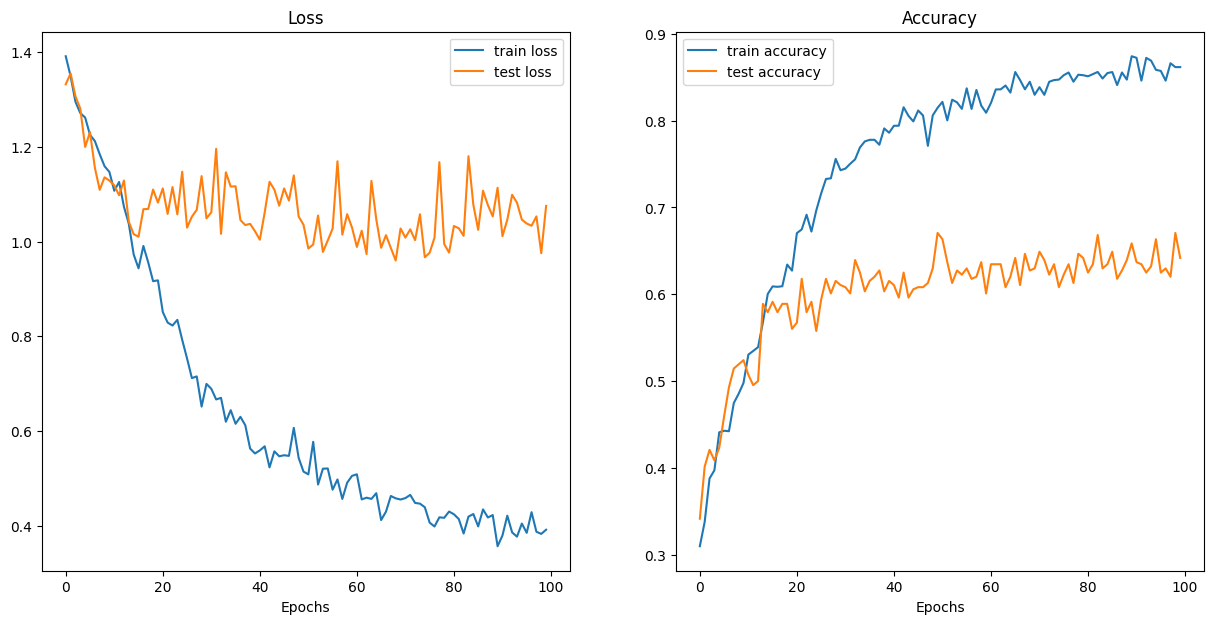

In [6]:
plot_loss_curves(model_4_results)

## 5.5 Construct and train **model_5**

### model_5

* EPOCHS = 100
* HIDDEN_UNITS = 200
* LEARNING_RATE = 0.001


In [7]:
# set the manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 
NUM_EPOCHS = 100
HIDDEN_UNITS = 200
LEARNING_RATE = 0.001


print(f"Total epochs: {NUM_EPOCHS}, \t Hidden units: {HIDDEN_UNITS}, \t Learning Rate: {LEARNING_RATE}")
print("\n---------------------------------------\n")

model_5 = InsectClassificationCNN(input_shape=3,
                                 hidden_units=HIDDEN_UNITS,
                                 output_shape=len(train_data_augmented.classes)).to(device)

# setup loss function and optimizer function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(),
                            lr=LEARNING_RATE)

from timeit import default_timer as  timer
# start time
model_5_start_time = timer()

model_5_results = train(model=model_5,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
# stop timer
model_5_stop_time = timer()

model_5_total_time = model_5_stop_time - model_5_start_time

print(f"The total time for training the models is: {model_5_total_time} seconds")

Total epochs: 100, 	 Hidden units: 200, 	 Learning Rate: 0.001

---------------------------------------



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.5940 | Train acc: 24.7036% | Test acc: 25.0000%
Epoch: 1 | Train loss : 1.3864 | Train acc: 24.4536% | Test acc: 25.0000%
Epoch: 2 | Train loss : 1.3864 | Train acc: 25.0121% | Test acc: 25.7212%
Epoch: 3 | Train loss : 1.3864 | Train acc: 23.8266% | Test acc: 25.0000%
Epoch: 4 | Train loss : 1.3863 | Train acc: 23.9597% | Test acc: 25.4808%
Epoch: 5 | Train loss : 1.3864 | Train acc: 23.8246% | Test acc: 25.7212%
Epoch: 6 | Train loss : 1.3864 | Train acc: 24.7077% | Test acc: 24.5192%
Epoch: 7 | Train loss : 1.3864 | Train acc: 23.8911% | Test acc: 25.0000%
Epoch: 8 | Train loss : 1.3864 | Train acc: 22.6371% | Test acc: 25.2404%
Epoch: 9 | Train loss : 1.3865 | Train acc: 23.2641% | Test acc: 25.0000%
Epoch: 10 | Train loss : 1.3864 | Train acc: 24.0141% | Test acc: 25.2404%
Epoch: 11 | Train loss : 1.3865 | Train acc: 24.0101% | Test acc: 25.2404%
Epoch: 12 | Train loss : 1.3864 | Train acc: 24.2560% | Test acc: 25.0000%
Epoch: 13 | Train loss : 1.3864 | T

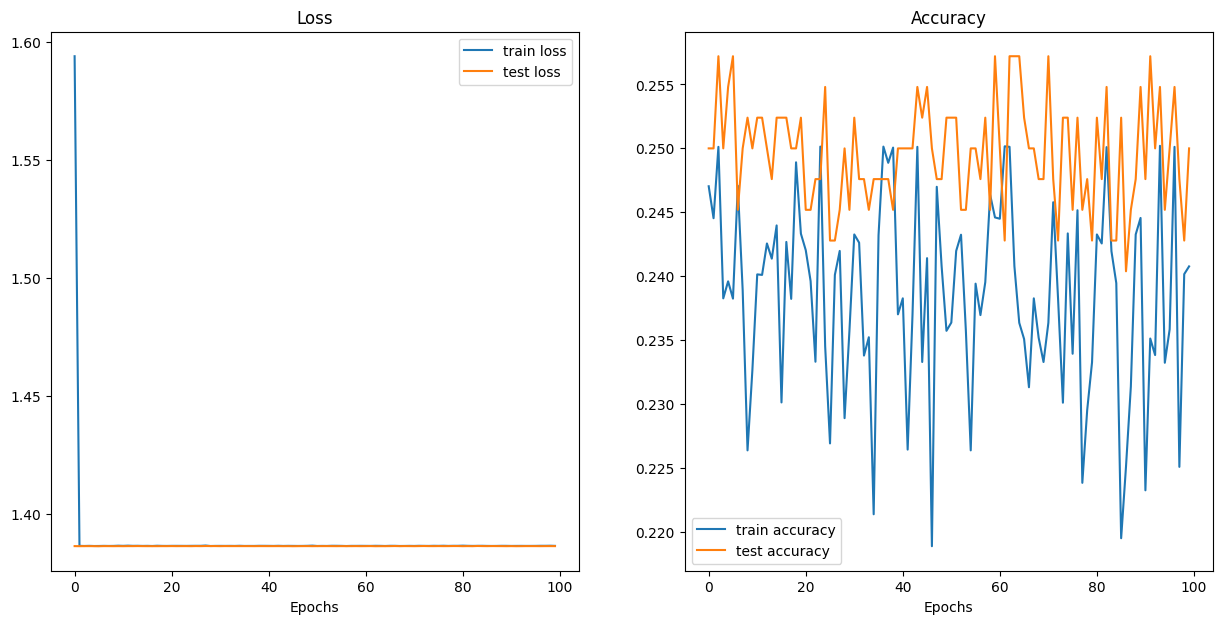

In [8]:
plot_loss_curves(model_5_results)

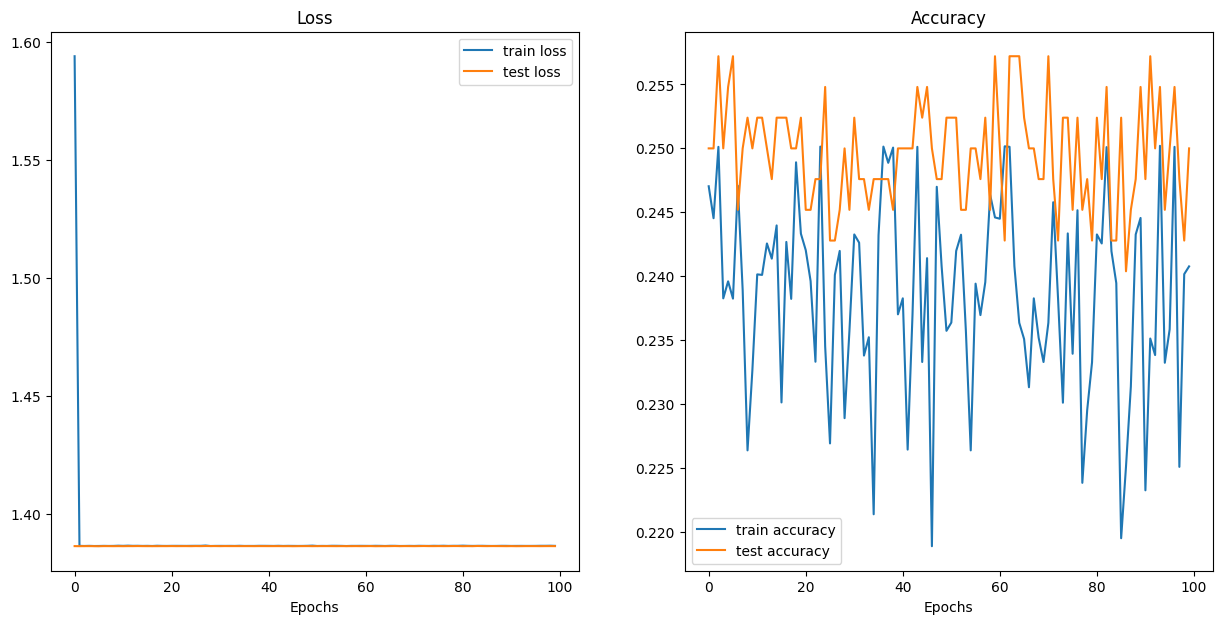

In [2]:
plot_loss_curves(model_5_results)

## 5.6 Construct and train **model_6**

### model_6

* EPOCHS = 500
* HIDDEN_UNITS = 80
* LEARNING_RATE = 0.001


In [5]:
# set the manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)


NUM_EPOCHS = 500
HIDDEN_UNITS = 80
LEARNING_RATE = 0.001


print(f"Total epochs: {NUM_EPOCHS}, \t Hidden units: {HIDDEN_UNITS}, \t Learning Rate: {LEARNING_RATE}")
print("\n---------------------------------------\n")

model_6 = InsectClassificationCNN(input_shape=3,
                                 hidden_units=HIDDEN_UNITS,
                                 output_shape=len(train_data_augmented.classes)).to(device)

# setup loss function and optimizer function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_6.parameters(),
                            lr=LEARNING_RATE)

from timeit import default_timer as  timer
# start time
model_6_start_time = timer()

model_6_results = train(model=model_6,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
# stop timer
model_6_stop_time = timer()

model_6_total_time = model_6_stop_time - model_6_start_time

print(f"The total time for training the models is: {model_6_total_time} seconds")

Total epochs: 500, 	 Hidden units: 80, 	 Learning Rate: 0.001

---------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.3922 | Train acc: 30.5262% | Test acc: 34.1346%
Epoch: 1 | Train loss : 1.3527 | Train acc: 31.7661% | Test acc: 40.1442%
Epoch: 2 | Train loss : 1.3035 | Train acc: 38.5887% | Test acc: 43.2692%
Epoch: 3 | Train loss : 1.2845 | Train acc: 39.0887% | Test acc: 45.4327%
Epoch: 4 | Train loss : 1.2566 | Train acc: 43.2722% | Test acc: 47.1154%
Epoch: 5 | Train loss : 1.2241 | Train acc: 43.4556% | Test acc: 46.8750%
Epoch: 6 | Train loss : 1.2312 | Train acc: 44.9012% | Test acc: 51.4423%
Epoch: 7 | Train loss : 1.2213 | Train acc: 46.4617% | Test acc: 46.6346%
Epoch: 8 | Train loss : 1.1960 | Train acc: 44.5403% | Test acc: 46.6346%
Epoch: 9 | Train loss : 1.1769 | Train acc: 46.7198% | Test acc: 48.0769%
Epoch: 10 | Train loss : 1.1655 | Train acc: 50.0323% | Test acc: 52.4038%
Epoch: 11 | Train loss : 1.1250 | Train acc: 52.5282% | Test acc: 53.1250%
Epoch: 12 | Train loss : 1.1071 | Train acc: 52.1653% | Test acc: 53.1250%
Epoch: 13 | Train loss : 1.0776 | T

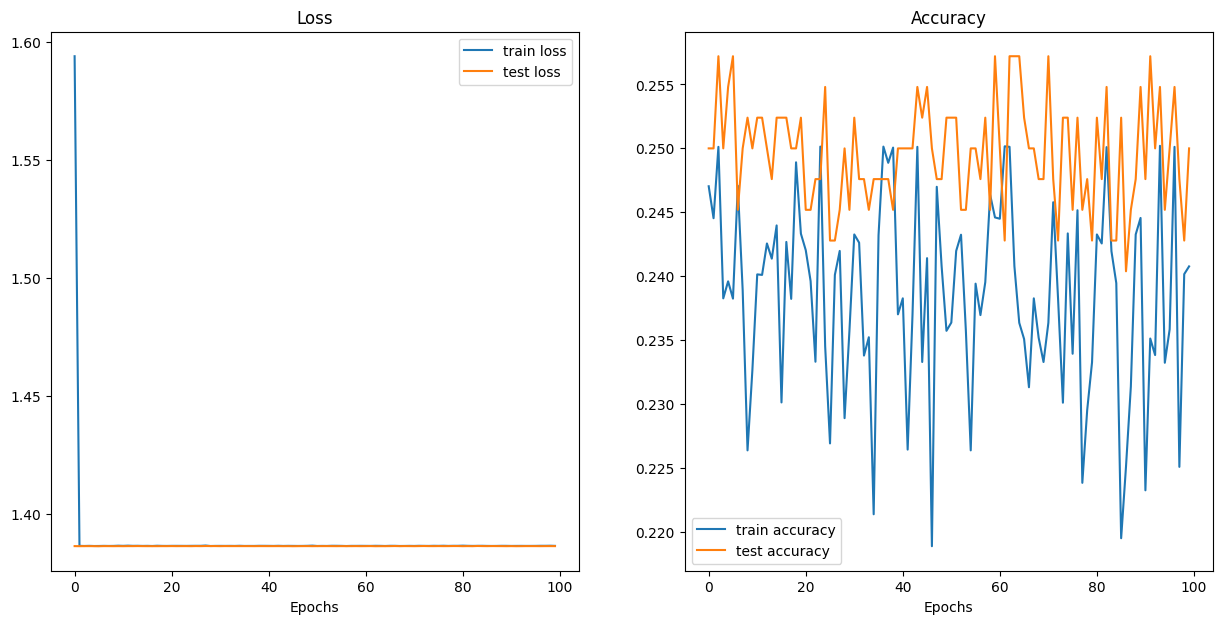

In [8]:
plot_loss_curves(model_5_results)

# 6. Compare model results

After evaluating our modeling experiments on their own, it's important to compare them to each other 

There are few different ways to do this:
* Hardcoding
* PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
* Wights & biases - https://wandb.ai/site/experiment-tracking
* MLFLow - https://mlflow.org/


In [ ]:
import pandas as pd
model_1_df = pd.DataFrame(model_1_results)
model_2_df = pd.DataFrame(model_2_results)
model_3_df = pd.DataFrame(model_3_results)
model_4_df = pd.DataFrame(model_4_results)
model_5_df = pd.DataFrame(model_5_results)


In [2]:
model_3_df

,train_loss,train_acc,test_loss,test_acc
0,1.380779,0.296351,1.315444,0.370192
1,1.339579,0.337722,1.319317,0.341346
2,1.335189,0.333931,1.271260,0.394231
3,1.284739,0.384516,1.271837,0.423077
4,1.268388,0.425222,1.220073,0.449519
5,1.248988,0.412077,1.272086,0.403846
6,1.230571,0.423347,1.252081,0.437500
7,1.197240,0.481512,1.304175,0.389423
8,1.184110,0.470867,1.184316,0.497596
9,1.165841,0.490343,1.144911,0.519231


## 5.7 Construct and train **model_7**

with LR scheduler 

### model_7

* EPOCHS = 50
* HIDDEN_UNITS = 80
* LEARNING_RATE = 0.001


In [3]:
# set the manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 
NUM_EPOCHS = 40
HIDDEN_UNITS = 80
LEARNING_RATE = 0.001


print(f"Total epochs: {NUM_EPOCHS}, \t Hidden units: {HIDDEN_UNITS}, \t Learning Rate: {LEARNING_RATE}")
print("\n---------------------------------------\n")

model_7 = InsectClassificationCNN(input_shape=3,
                                 hidden_units=HIDDEN_UNITS,
                                 output_shape=len(train_data_augmented.classes)).to(device)

# setup loss function and optimizer function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_7.parameters(),
                            lr=LEARNING_RATE,
                            betas=(0.9, 0.999),
                            weight_decay=0.0001)

from timeit import default_timer as  timer
# start time
model_7_start_time = timer()

model_7_results = train(model=model_7,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# stop timer
model_7_stop_time = timer()

model_7_total_time = model_7_stop_time - model_7_start_time

print(f"The total time for training the models is: {model_7_total_time} seconds")

Total epochs: 40, 	 Hidden units: 80, 	 Learning Rate: 0.001

---------------------------------------



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.4046 | Train acc: 29.6472% | Test acc: 29.8077%
Epoch: 1 | Train loss : 1.3483 | Train acc: 33.4617% | Test acc: 38.4615%
Epoch: 2 | Train loss : 1.2946 | Train acc: 37.4012% | Test acc: 44.2308%
Epoch: 3 | Train loss : 1.2785 | Train acc: 39.9617% | Test acc: 43.0288%
Epoch: 4 | Train loss : 1.2847 | Train acc: 39.4617% | Test acc: 45.1923%
Epoch: 5 | Train loss : 1.2442 | Train acc: 42.8306% | Test acc: 41.3462%
Epoch: 6 | Train loss : 1.2441 | Train acc: 41.8891% | Test acc: 44.9519%
Epoch: 7 | Train loss : 1.2163 | Train acc: 44.0887% | Test acc: 51.4423%
Epoch: 8 | Train loss : 1.1875 | Train acc: 47.6653% | Test acc: 48.5577%
Epoch: 9 | Train loss : 1.1997 | Train acc: 44.7177% | Test acc: 52.6442%
Epoch: 10 | Train loss : 1.1627 | Train acc: 48.5948% | Test acc: 49.2788%
Epoch: 11 | Train loss : 1.1533 | Train acc: 49.9073% | Test acc: 51.2019%
Epoch: 12 | Train loss : 1.1287 | Train acc: 50.9093% | Test acc: 53.6058%
Epoch: 13 | Train loss : 1.1157 | T

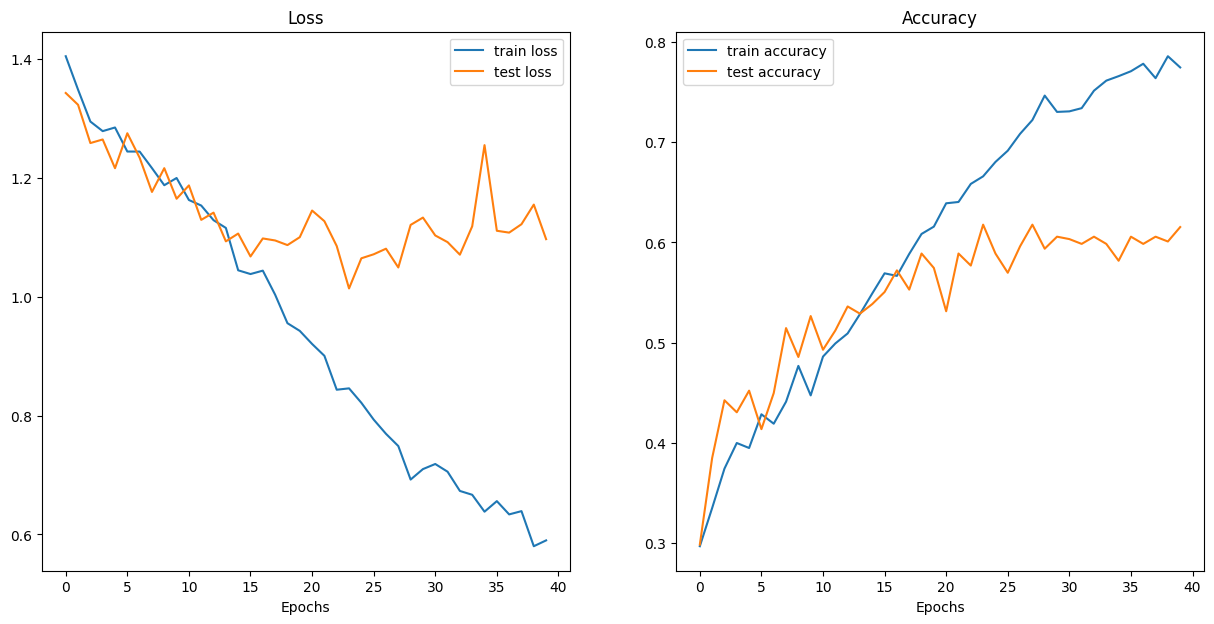

In [10]:
plot_loss_curves(model_7_results)

### model_8

* EPOCHS = 200
* HIDDEN_UNITS = 80
* LEARNING_RATE = 0.001


In [8]:
# set the manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 
NUM_EPOCHS = 150
HIDDEN_UNITS = 80
LEARNING_RATE = 0.001


print(f"Total epochs: {NUM_EPOCHS}, \t Hidden units: {HIDDEN_UNITS}, \t Learning Rate: {LEARNING_RATE}")
print("\n---------------------------------------\n")

model_8 = InsectClassificationCNN(input_shape=3,
                                 hidden_units=HIDDEN_UNITS,
                                 output_shape=len(train_data_augmented.classes)).to(device)

# setup loss function and optimizer function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_8.parameters(),
                            lr=LEARNING_RATE,
                            betas=(0.9, 0.999),
                            weight_decay=0.0001,
                            amsgrad=True)

from timeit import default_timer as  timer
# start time
model_8_start_time = timer()

model_8_results = train(model=model_8,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# stop timer
model_8_stop_time = timer()

model_8_total_time = model_8_stop_time - model_8_start_time

print(f"The total time for training the models is: {model_8_total_time} seconds")

Total epochs: 150, 	 Hidden units: 80, 	 Learning Rate: 0.001

---------------------------------------



  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0 | Train loss : 1.4065 | Train acc: 30.4496% | Test acc: 37.2596%
Epoch: 1 | Train loss : 1.3187 | Train acc: 35.4577% | Test acc: 40.6250%
Epoch: 2 | Train loss : 1.2827 | Train acc: 40.9073% | Test acc: 40.1442%
Epoch: 3 | Train loss : 1.2762 | Train acc: 42.6552% | Test acc: 40.1442%
Epoch: 4 | Train loss : 1.2664 | Train acc: 43.0242% | Test acc: 43.5096%
Epoch: 5 | Train loss : 1.2268 | Train acc: 44.2198% | Test acc: 52.4038%
Epoch: 6 | Train loss : 1.2071 | Train acc: 45.7258% | Test acc: 49.0385%
Epoch: 7 | Train loss : 1.1665 | Train acc: 49.0282% | Test acc: 50.4808%
Epoch: 8 | Train loss : 1.1610 | Train acc: 49.1552% | Test acc: 52.8846%
Epoch: 9 | Train loss : 1.1323 | Train acc: 52.0948% | Test acc: 55.5288%
Epoch: 10 | Train loss : 1.1339 | Train acc: 49.7823% | Test acc: 53.1250%
Epoch: 11 | Train loss : 1.1266 | Train acc: 51.6492% | Test acc: 52.6442%
Epoch: 12 | Train loss : 1.1120 | Train acc: 51.9637% | Test acc: 54.3269%
Epoch: 13 | Train loss : 1.0686 | T

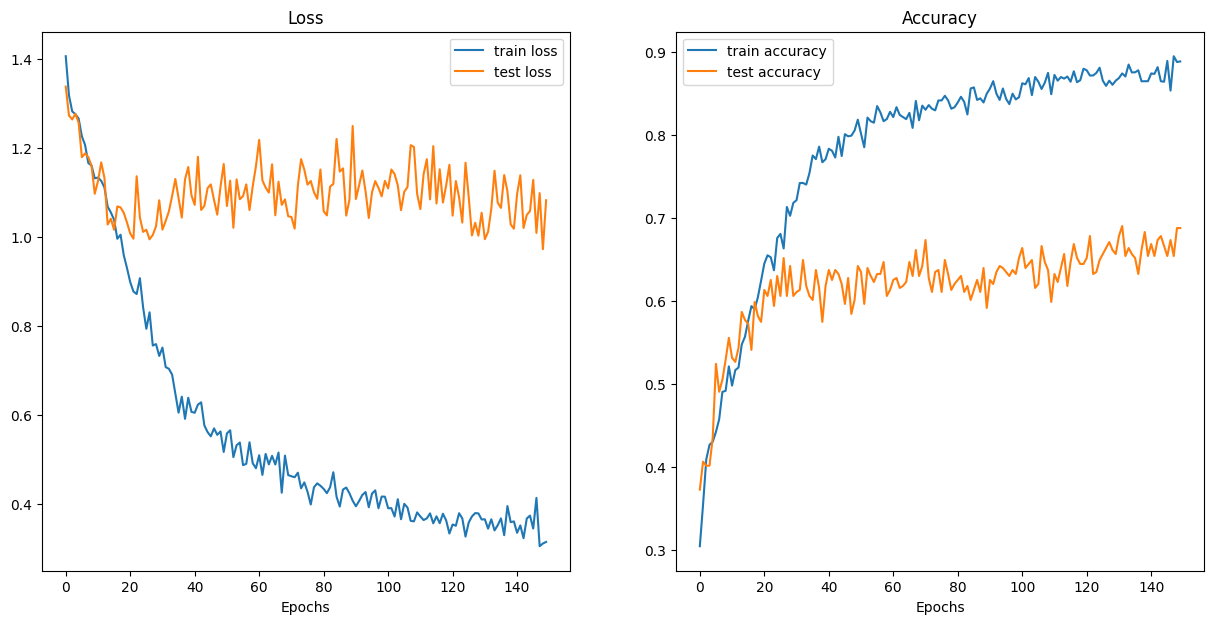

In [9]:
plot_loss_curves(model_8_results)